## Introduction

Is there a statistically significant difference between subject and object frequencies for feminine and masculine personal pronouns?

Is is possible to predict the gender of a character in a story using the pronouns around them?

Yes

He and she are subjective pronouns (easy to identify)

Him and her are objective pronouns
- Him is easy to identify, but her is both a objective pronoun and a possessive adjective. To discriminate between the two, we wrote a function to perform POS tagging and then identify instances of the word "her" that were NOT followed by a noun (either a NN or NNS type). These instances of "her" were counted as objective, and the rest were counted as possessive.

His and her are possessive adjectives

His and hers are possessive pronouns
- "His" is both a possessive adjective and a possesive pronouns. For the purpose of our project, we did not distinguish between the two and sorted them both as male pronouns.


## Methodology

Datasets: *Pride and Prejudice* by Jane Austen; *Frankenstein: Or, the Modern Prometheus* by Mary Shelley; and *Wuthering Heights* by Emily Brontë all taken from Calvin's Project Gutenberg repository.

Technologies: **SparkNLP** (for POS-tagging) and **Spacy** (for Named-Entity Recognition)

Process:
1. Identified corpus of interest
2. Run all books through a cleaner (removes periods after honorifics since we split into sentences by splitting on periods. Also removed hyphens)
3. Add periods back in to aid in identifying instances of the objective "her" (Possessive adjective "her" instances are followed by nouns, and without the periods, the function may mistakenly identify objective "her"s as possessive if the following sentence starts with a noun)
4. Find all the people in each sentence, and count the instances of male and female pronouns in that sentence. Added person with the counts to a dictionary with the name as the key
5. Convert dictionary to list to iterate through list
6. Drop any characters with a total pronoun count of fewer than 10.
7. Make prediction for each character based off the pronoun counts
8. The function "manually_verify" manually verifies whether a character is a man or a woman by asking the user to identify if a character is male or female
9. It compares the true values entered to the predicted values to produce the final accuracy for all of the male and female characters. We get total accuracy, male accuracy, and female accuracy.

## Hypotheses

1. Because all of our books in the corpus are written by women, we predict that there will be no statistical difference between the subjective male counts, subjective female counts, objective male counts, and objective female counts.

2. We predict that we can predict the gender of a character given the count of male vs female pronouns in the sentences in which they are mentioned with better accuracy than a coin flip.

## Evaluation

For the character evaluator, it was a simple accuracy check: the predicted results divided by the actual values. We split it by book, so we could get a gauge of how well the model performs on each book. We also measured the accuracy by gender, and found that the accuracy by gender varied for each book, though Frakenstein performed the best in all categories with a 100% accuracy (likely due to the small number of characters).

For the frequencies of male vs female subjective vs objective pronouns, we found that the differences for male subjective vs female subjective and male objective vs female objective were not statistically significant.

## Conclusion



pip installs, library imports, and global vars

In [ ]:
%pip install sparknlp
%pip install pyspark
%pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=707337dd4c4ddc6bbfefb9b0b7c783570dbda6b415fc9ed370b6eca650ef4ec3
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import sparknlp
import os
import spacy
import pyspark
from pyspark.sql import SparkSession
from tqdm import tqdm
import datetime
import pandas as pd
from sparknlp.pretrained import PretrainedPipeline
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
spark = sparknlp.start()
root = os.path.dirname(os.path.realpath('cormac.ipynb'))
pipeline = PretrainedPipeline("explain_document_ml")

explain_document_ml download started this may take some time.
Approx size to download 9 MB
[OK!]


get corpus

In [ ]:
book_list = ['pg1342.txt', 'pg768.txt', 'pg84.txt']
# curl each book
for book in book_list:
  !curl "https://raw.githubusercontent.com/cd-public/books/main/{book}" -o {book}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  739k  100  739k    0     0  1707k      0 --:--:-- --:--:-- --:--:-- 1708k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  665k  100  665k    0     0  2562k      0 --:--:-- --:--:-- --:--:-- 2558k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  430k  100  430k    0     0  1187k      0 --:--:-- --:--:-- --:--:-- 1190k


In [ ]:
def read_txt(filename = 'pg1342.txt'):
  file = open(root + '/' + filename,"r")
  return file.read()
pride = read_txt()
frank = read_txt('pg84.txt')
wuther = read_txt('pg768.txt')

In [ ]:
pronouns = ['he','him','his','she','her','hers']
def pronoun_check(x):
  '''
  x = list of tuples
  returns list of tuples with only pronouns
  '''
  pro_toks = []
  male_count, female_count = 0, 0
  for i in x:
    flag = False
    last_pos = ''
    last_tok = ''
    for y in i:
      if flag:
        if pos != 'NN' and pos != 'NNS' and token == '.':
          female_count += 1
          flag = False
          continue
      token, pos = y
      token = token.lower()
      # Magic (identifies instances of 'her' that are objective)
      if token in pronouns:
        if token == 'her':
          flag = True
          last_pos = pos
          last_tok = token
        else:
            if token == 'he' or token == 'him':
              male_count += 1
            else:
              female_count += 1

  return male_count, female_count

#def count_pronouns(x):

In [ ]:
def count_subObjPos(x):
  '''
  x = list of tuples
  returns count of instances of each type of pronoun
  '''
  pro_toks = []
  male_countSub, female_countSub, male_countObj, female_countObj, male_countPos, female_countPos = 0, 0, 0, 0, 0, 0
  male_count, female_count = 0, 0
  for i in x:
    flag = False
    last_pos = ''
    last_tok = ''
    for y in i:
      if flag:
        if pos != 'NN' and pos != 'NNS' and token == '.':
          female_countObj += 1
          flag = False
        else:
          female_countPos += 1
          flag = False
          continue
      token, pos = y
      token = token.lower()
      # Magic (identifies instances of 'her' that are objective)
      if token in pronouns:
        if token == 'her':
          flag = True
          last_pos = pos
          last_tok = token
        else:
            if token == 'he':
              male_countSub += 1
            elif token == 'him':
              male_countObj += 1
            elif token == 'she':
              female_countSub += 1
            elif token == 'hers':
              female_countPos += 1
            elif token == 'his':
              male_countPos += 1
  male_count = male_countSub + male_countObj + male_countPos
  female_count = female_countSub + female_countObj + female_countPos

  return male_count, female_count, male_countSub, female_countSub, male_countObj, female_countObj, male_countPos, female_countPos

In [ ]:
def book_cleaner(text):
  text = text.replace('Mr.','Mr')
  text = text.replace('Mrs.','Mrs')
  text = text.replace('Ms.','Ms')
  text = text.replace('Dr.','Dr')
  text = text.replace('_','')
  text = text.replace('-','')
  # text = text.replace('\n', ' ')
  # text = text.replace('""',' ')
  # text = text.replace('  ',' ')
  # # text = text.lower()
  return text

pridesplit = book_cleaner(pride).split('.')
franksplit = book_cleaner(frank).split('.')
wuthersplit = book_cleaner(wuther).split('.')

In [ ]:
def period(sentences):
  sent_list = []
  for sent in sentences:
    sent = sent+'.'
    sent_list.append(sent)
  return sent_list
pridesplit = period(pridesplit)
franksplit = period(franksplit)
wuthersplit = period(wuthersplit)

for each sentence, find all people mentiond. Add the number of male and female pronounce counted in the sentence to a dict where the key is the persons name.

In [ ]:
def book_person_dict_builder(split_book):
  nlp = spacy.load('en_core_web_sm')
  personGenderCount = {} # person: malePronounCount, femalePronounCount
  # for sent in pridesplit:
  for sent in tqdm(split_book): # for each sentence in pride
    doc = nlp(sent) # create the spacy doc
    people = []
    for ent in doc.ents:
      if ent.label_ == 'PERSON':
        people.append(ent.text) # get all people entities
    if len(people) == 0: # if there aren't any people
      continue # move onto next sentence
    annoted_sent = pipeline.annotate(sent) # annotate the sentence with parts of speach
    tok_tag = [(annoted_sent['token'], annoted_sent['pos'])] # list of tuples (token, part of speech)
    zips = [list(zip(tt[0],tt[1])) for tt in tok_tag] # zip
    male_count, female_count,_,_,_,_,_,_ = count_subObjPos(zips) # get male/female PN counts
    for person in people: # for each person in the sentence
      try: # if they already exist in the the dict
        # add the old counts to the new
        person_male_count = personGenderCount[person][0]
        person_female_count = personGenderCount[person][1]
        personGenderCount[person] = person_male_count + male_count, person_female_count + female_count
      except KeyError: # if they don't exist in the dict, add them
        personGenderCount[person] = male_count, female_count

  return personGenderCount

pride_dict = book_person_dict_builder(pridesplit)
frank_dict = book_person_dict_builder(franksplit)
wuther_dict = book_person_dict_builder(wuthersplit)


100%|██████████| 4922/4922 [10:55<00:00,  7.51it/s]


convert dict to list so we can itterate through it

In [ ]:
def dict_to_list(dict):
  # convert personGenderCount to list
  out = []
  for key, value in dict.items():
    m_count, f_count = value[0], value[1]
    if m_count + f_count < 10:
      continue
    out.append([key, value[0], value[1]])
  return out

personGenderList_pride = dict_to_list(pride_dict)
personGenderList_frank = dict_to_list(frank_dict)
personGenderList_wuther = dict_to_list(wuther_dict)


manually verify each persons gender (do not presume to know unless prefaced by Mr, Mrs, ... etc)

In [ ]:
def manual_verify(personGenderList, book):
  out_list = [] # will consist of [name, prediction, actual]
  try:
    old_out_file = pd.read_csv(book + '_output' + '.csv')
  except:
    old_out_file = []
  for person in personGenderList:
    name, male_count, female_count = person[0], person[1], person[2]
    prediciton = 1 if male_count > female_count else 0
    if len(old_out_file) > 0:
      if name in old_out_file['name'].values:
        actual = old_out_file[old_out_file['name'] == name]['actual'].values[0]
    else:
      actual = input('Is ' + name + ': ' + str(prediciton) + '? ') # 1 for M, 0 for F, -1 for other
    out_list.append([name, prediciton, actual])
  return out_list

out_list_pride = manual_verify(personGenderList_pride, 'pride')
out_list_frank = manual_verify(personGenderList_frank, 'frank')
out_list_wuther = manual_verify(personGenderList_wuther, 'wuther')

Is Mary: 0? 0
Is Austen: 0? 0
Is Wickham: 1? 1
Is Jane: 0? 0
Is Darcy: 1? 1
Is Elizabeth: 0? 0
Is Bennet: 0? 0
Is Collins: 1? 1
Is Mrs
Bennet: 1? 0
Is Mrs Bennet: 0? 0
Is Mr Collins: 1? 1
Is Lady Catherine de Bourgh: 1? 0
Is Lady Catherine: 0? 0
Is Kitty: 0? 0
Is Mrs Bennet’s: 0? 0
Is Bingleys: 0? 1
Is Pemberley: 0? -1
Is Mr Bingley: 0? 1
Is Lizzy: 0? 0
Is Mrs Long: 1? 0
Is Bingley: 0? 1
Is William: 1? 1
Is Lydia: 0? 0
Is Mrs Hurst: 0? 0
Is Catherine: 1? 0
Is Maria Lucas: 0? 0
Is Miss Bingley: 0? 0
Is Miss Bennet: 1? 0
Is William Lucas: 1? 1
Is Lucas Lodge: 1? -1
Is Lucas: 0? 0
Is Robinson: 1? 1
Is Forster: 1? 1
Is Meryton: 1? -1
Is Mrs Philips: 0? 0
Is Miss
Bennet: 0? 0
Is Charles: 1? 1
Is Jones: 0? 1
Is Netherfield: 0? -1
Is Gardiner: 1? 1
Is Miss de Bourgh: 0? 0
Is Denny: 1? 1
Is Lady Catherine de
Bourgh: 1? 0
Is Mr Wickham: 1? 1
Is Mr
Wickham: 0? 1
Is Lady
Catherine: 0? 0
Is Rosings: 0? -1
Is De Bourgh: 0? 0
Is George Wickham: 1? 1
Is Mrs Jenkinson: 0? 0
Is Mrs Gardiner: 0? 0
Is Mr

save to file

In [ ]:
def save_books_person_dict(out_list, book):
  df = pd.DataFrame(out_list, columns=['name', 'prediction', 'actual'])
  df = df.astype({'actual': int})
  df.to_csv(book + '_output' + '.csv', index=False)
  return df

df_pride = save_books_person_dict(out_list_pride, 'pride')
df_frank = save_books_person_dict(out_list_frank, 'frank')
df_wuther = save_books_person_dict(out_list_wuther, 'wuther')

In [ ]:
# df[df['name'] == 'ellen'][actual] = 0
df_wuther.loc[df_wuther['name'] == 'Ellen', 'actual'] = 0

calculate accuracy

In [ ]:
def accuracy_calc(df, book):
  print(f'Book: {book}')
  # calculate accuracy, when predicted == actual that's good
  accuracy = (df['prediction'] == df['actual']).sum() / len(df)
  print(f'Total Accuracy: {round(accuracy*100,2)}%')
  # female accuracy
  female_df = df[df['actual'] == 0]
  female_accuracy = (female_df['prediction'] == female_df['actual']).sum() / len(female_df)
  print(f'Female Accuracy: {round(female_accuracy*100,2)}%')
  # male accuracy
  male_df = df[df['actual'] == 1]
  male_accuracy = (male_df['prediction'] == male_df['actual']).sum() / len(male_df)
  print(f'Male Accuracy: {round(male_accuracy*100,2)}%\n')

accuracy_calc(df_pride, 'Pride and Prejudice')
accuracy_calc(df_frank, 'Frakenstein')
accuracy_calc(df_wuther, 'Wuthering Heights')
df_all = pd.concat([df_pride, df_frank, df_wuther])
accuracy_calc(df_all, 'All Books')

Book: Pride and Prejudice
Total Accuracy: 72.13%
Female Accuracy: 83.33%
Male Accuracy: 73.68%

Book: Frakenstein
Total Accuracy: 100.0%
Female Accuracy: 100.0%
Male Accuracy: 100.0%

Book: Wuthering Heights
Total Accuracy: 64.52%
Female Accuracy: 57.14%
Male Accuracy: 92.31%

Book: All Books
Total Accuracy: 72.28%
Female Accuracy: 76.92%
Male Accuracy: 84.62%



Book: Pride and Prejudice
Total Accuracy: 72.13%
Female Accuracy: 83.33%
Male Accuracy: 73.68%

Book: Frankenstein
Total Accuracy: 100.0%
Female Accuracy: 100.0%
Male Accuracy: 100.0%

Book: Wuthering Heights
Total Accuracy: 64.52%
Female Accuracy: 57.14%
Male Accuracy: 92.31%

Book: All Books
Total Accuracy: 72.28%
Female Accuracy: 76.92%
Male Accuracy: 84.62%



TypeError: cannot unpack non-iterable NoneType object

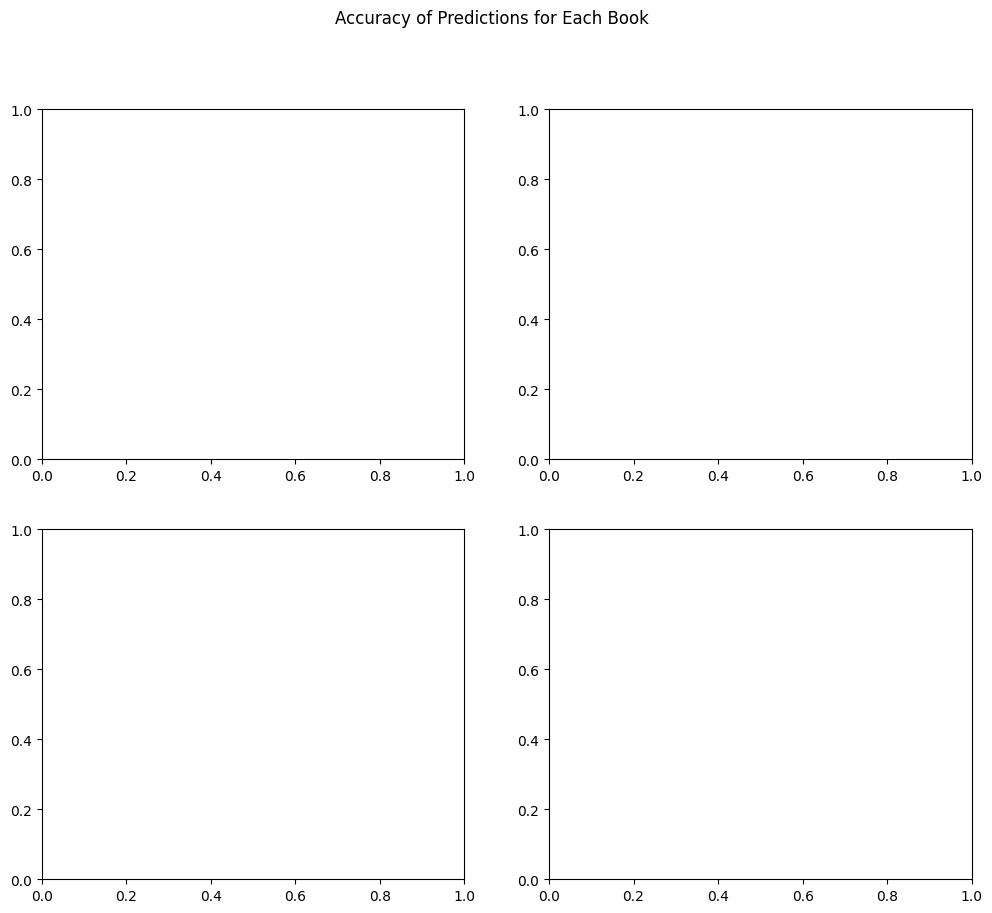

In [ ]:
books = [
    accuracy_calc(df_pride, 'Pride and Prejudice'),
    accuracy_calc(df_frank, 'Frankenstein'),
    accuracy_calc(df_wuther, 'Wuthering Heights')
]

df_all = pd.concat([df_pride, df_frank, df_wuther])
books.append(accuracy_calc(df_all, 'All Books'))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Accuracy of Predictions for Each Book')

for i, (book, total_acc, female_acc, male_acc) in enumerate(books):
    ax = axs[i//2, i%2]
    ax.bar(['Total', 'Female', 'Male'], [accuracy, female_accuracy, male_accuracy], color=['green', 'purple', 'orange'])
    ax.set_title(book)
    ax.set_ylim([0, 100])
    for index, value in enumerate([total_acc, female_acc, male_acc]):
        ax.text(index, value + 1, f'{value:.2f}%', ha='center')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

very good at predicting female characters, terrible at predicting males. This probably indicates the main subjectmatter of this book is women (idk). perhaps we can use this to predict the authors gender.

In [ ]:
# Pronoun Frequencies

#xs = ['1', '2', '3']
#s = ''.join(xs)

books = [' '.join(pridesplit), ' '.join(franksplit,),  ' '.join(wuthersplit)]

def analyze_pronouns(corpus):
    """
    corpus: list of documents where each document is a list of tuples
            with (token, pos) representing token and its part-of-speech.
    returns: dictionary with t-test results for male and female pronoun counts.
    """
    male_countSub_list = []
    female_countSub_list = []
    male_countObj_list = []
    female_countObj_list = []


    for doc in corpus:
      annoted_sent = pipeline.annotate(doc) # annotate the sentence with parts of speach
      tok_tag = [(annoted_sent['token'], annoted_sent['pos'])] # list of tuples (token, part of speech)
      zips = [list(zip(tt[0],tt[1])) for tt in tok_tag]
      male_count, female_count, male_countSub, female_countSub, male_countObj, female_countObj, male_countPos, female_countPos = count_subObjPos(zips)

      male_countSub_list.append(male_countSub)
      female_countSub_list.append(female_countSub)
      male_countObj_list.append(male_countObj)
      female_countObj_list.append(female_countObj)

    # Perform t-tests
    ttest_results = {}

    ttest_results['male_sub_vs_female_sub'] = stats.ttest_ind(male_countSub_list, female_countSub_list, equal_var=False)
    ttest_results['male_obj_vs_female_obj'] = stats.ttest_ind(male_countObj_list, female_countObj_list, equal_var=False)

    print()

    return ttest_results

In [ ]:
ttest = analyze_pronouns(books)

In [ ]:
ttest

{'male_sub_vs_female_sub': TtestResult(statistic=0.3494248499038809, pvalue=0.7447884187988674, df=3.9070161694515866),
 'male_obj_vs_female_obj': TtestResult(statistic=3.055041023701978, pvalue=0.09251528184878668, df=2.0)}